<a href="https://colab.research.google.com/github/madhavanr29/Competitive-Projects/blob/master/multi_label_transformer_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing huggingface-transformers library which gives efficient access to complex transformer based pre trained models**





For reference : https://huggingface.co/transformers/

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 7.4MB/s 
     |████████████████████████████████| 890kB 18.9MB/s 
     |████████████████████████████████| 1.1MB 40.8MB/s 
     |████████████████████████████████| 3.0MB 40.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=9928621d1ac633b1eb84771d5de69984109afe8e9939ae4fa407cc73c05fbe92
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


##Importing other necessary libraries

In [ ]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

## Checking for GPU availability

In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla K80


##Reading the training and testing dataset

In [ ]:
training = pd.read_csv('/content/drive/My Drive/train.csv', index_col='ID')
testing = pd.read_csv('/content/drive/My Drive/test.csv', index_col='ID')

## As we have 2 text columns in the dataset. Lets combine it together using a 'sep' token which indicates a sentence seperator

In [ ]:
train_text_list = training['TITLE'] + ' [SEP] ' + training['ABSTRACT']
train_text_list = train_text_list.values
test_text_list = testing['TITLE'] + ' [SEP] ' + testing['ABSTRACT']
test_text_list  = test_text_list.values

##**CHOOSING THE TRANSFORMER MODEL WHICH I WANT TO WORK ON**

Note: For more info refer https://huggingface.co/transformers/tokenizer_summary.html 

In [ ]:
transformer_models = ['gpt2','bert-base-uncased',  'xlnet-base-uncased', 'albert-base-v2', 'allenai/scibert_scivocab_uncased']
now_model = transformer_models[0]


## Lets use the tokenizer from the transformers module . <br> Note: Instead of importing tokenizers for each individual transformer model , as we are trying to work with multiple transformer based models like bert, xlnet, sci-bert , al-bert and gpt 2  lets import AutoTokenizer and pass the required pretrained models

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(now_model)

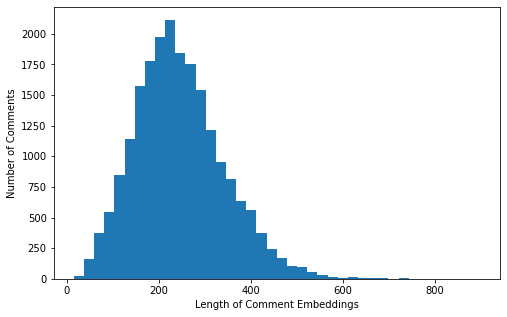

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

plot_sentence_embeddings_length(train_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 5 for
    # the special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings- 5], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> or [CLS] and [SEP] to the beginning and end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# creating input id tokens for train
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings= 300)
train_input_ids

array([[ 6690,   261,  7249, ...,     0,     0,     0],
       [   49, 14221, 10001, ...,     0,     0,     0],
       [ 4561, 37910,  7514, ...,     0,     0,     0],
       ...,
       [ 2025, 26266,   278, ...,     0,     0,     0],
       [ 2202,   262,   412, ...,     0,     0,     0],
       [ 5195, 11902, 12225, ...,     0,     0,     0]])

In [ ]:
# creating input id tokens for test
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings= 300)
test_input_ids

array([[ 2601,  1335,    12, ...,     0,     0,     0],
       [42230,  2870,  3095, ...,     0,     0,     0],
       [20448,  1114, 36125, ...,     0,     0,     0],
       ...,
       [39358, 15854,   532, ...,     0,     0,     0],
       [24915,  4035,   262, ...,     0,     0,     0],
       [29071,    12, 32707, ...,     0,     0,     0]])

In [ ]:
# creating attention masks for train
train_attention_masks = create_attn_masks(train_input_ids)

In [ ]:
# creating attention masks for test
test_attention_masks = create_attn_masks(test_input_ids)

In [ ]:
## lets add input id's and attention masks in our dataset
training["features"] = train_input_ids.tolist()
training["masks"] = train_attention_masks

testing["features"] = test_input_ids.tolist()
testing["masks"] = test_attention_masks

##TRAIN VALIDATION SPLIT

In [ ]:

trainy, valid = train_test_split(training, test_size=0.15, random_state= 50)

In [ ]:
X_train = trainy["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = trainy["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

Y_train = trainy.iloc[:,2:8].values.tolist()
Y_valid = valid.iloc[:,2:8].values.tolist()

In [ ]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.half)
valid_masks = torch.tensor(valid_masks, dtype=torch.half)

## CREATING DATALOADERS

In [ ]:
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

##Lets define our model class. As we know that we are performing multi label text classification we need to add an additional linear layer (output layer) specifying the 'num_labels' as no of label columns - 6 in this case

####Note: When using large transformer models such as bert-large we need to change the dimension of our last layer to (1024, num_labels) from (768,num_labels) as the hidden units for those are 1024

In [ ]:
from transformers import AutoModel

class MultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(MultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.the_model = AutoModel.from_pretrained(now_model)
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.the_model(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_the_decoder(self):
    """
    Freeze weight parameters. They will not be updated during training.
    """
    for param in self.the_model.parameters():
      param.requires_grad = False
    
  def unfreeze_the_decoder(self):
    """
    Unfreeze weight parameters. They will be updated during training.
    """
    for param in self.the_model.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = MultiLabelSequenceClassification(num_labels=len(Y_train[0]))

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
torch.cuda.empty_cache()

## Lets define the training function

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += float(loss.item())
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))
    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += float(loss.item())
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set




##Saving the model to the path directory provided

In [ ]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  

##Loading the model from the path directory provided


In [ ]:
def load_model(save_path):

  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = MultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
import gc
gc.collect()

338

##Using the adamw optimizer and setting a learning rate .
## Note: EACH PRE TRAINED MODEL WAS TUNED BASED ON DIFFERENT LEARNING RATE

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

## TRAINING THE MODEL FOR 2 EPOCHS AND SAVING IT AT A SPECIFIED PATH

In [ ]:
torch.cuda.empty_cache()
num_epochs= 2

gwd = os.getcwd()
model_save_path = output_model_file = os.path.join(gwd, "drive/My Drive/gpt2.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer= optimizer,
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.013527274355384271
Valid loss: 0.011132294807088125


Epoch:  50%|█████     | 1/2 [11:11<11:11, 671.89s/it]

Saving model at epoch 0 with validation loss of 0.011132294807088125


Train loss: 0.010261284923675177
Valid loss: 0.010810830369260154


Epoch: 100%|██████████| 2/2 [22:18<00:00, 669.48s/it]

Saving model at epoch 1 with validation loss of 0.010810830369260154




In [ ]:
gwd = os.getcwd()
model_save_path = output_model_file = os.path.join(gwd, "drive/My Drive/gpt2.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import gc
gc.collect()

16726

## TRAINING THE MODEL FROM CHECKPOINT FOR ANOTHER TWO EPOCHS <br> Note: As we defined the function to save the model with the lowest validation we can see that the validation loss didnot decrease for the 3rd and 4th epoch. 

In [ ]:
num_epochs= 2
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.009197434730506814


Epoch:  50%|█████     | 1/2 [11:04<11:04, 664.92s/it]

Valid loss: 0.010810830369260154


Train loss: 0.009201568303614918


Epoch: 100%|██████████| 2/2 [22:10<00:00, 665.16s/it]

Valid loss: 0.010810830369260154




In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

##Predictions on the training set  (To adjust probability cutoff because we are dealing with multi label classification)

In [ ]:
num_labels = 6
train_pred = generate_predictions(model, training, num_labels, device="cuda", batch_size=16)
train_pred

array([[4.23691452e-01, 1.82962324e-02, 1.10180695e-02, 8.92379940e-01,
        8.80635902e-02, 1.33587793e-03],
       [9.25777495e-01, 6.74745906e-03, 2.00019771e-04, 3.83399338e-01,
        2.62898463e-03, 4.04182007e-04],
       [4.85044643e-02, 5.29042147e-02, 8.69564712e-01, 1.35922730e-02,
        5.40399051e-04, 9.06618894e-04],
       ...,
       [7.65205503e-01, 2.65354067e-02, 1.44127558e-03, 6.59885406e-01,
        4.40604333e-03, 1.54721120e-03],
       [1.52900457e-01, 1.22749582e-02, 4.81304735e-01, 8.46812725e-01,
        1.93721452e-03, 4.96710502e-02],
       [9.35207754e-02, 1.17747514e-02, 3.21707785e-01, 9.81796861e-01,
        9.56869498e-03, 1.40323350e-02]])

In [ ]:
sub_in_ord = ['Computer Science', 'Physics', 'Mathematics', 'Statistics','Quantitative Biology', 'Quantitative Finance']
train_check = pd.DataFrame(train_pred, columns = sub_in_ord)
train_check.index =training.index

In [ ]:
train_lab = training.select_dtypes(int)

## PRECISION-RECALL CURVE

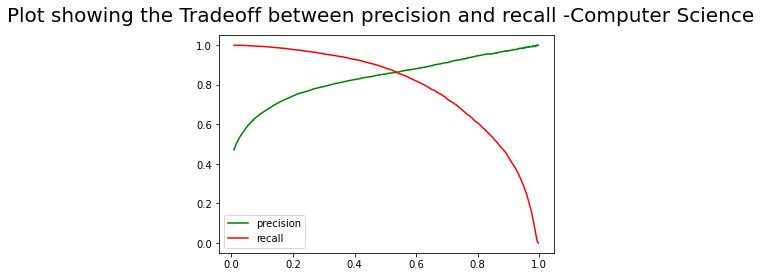

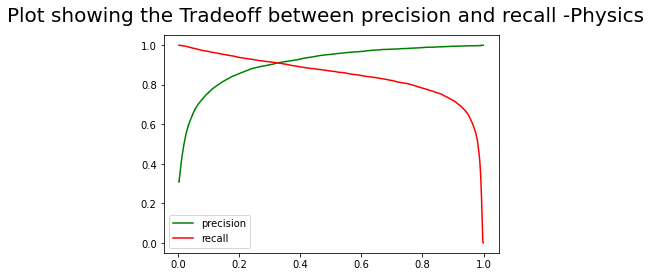

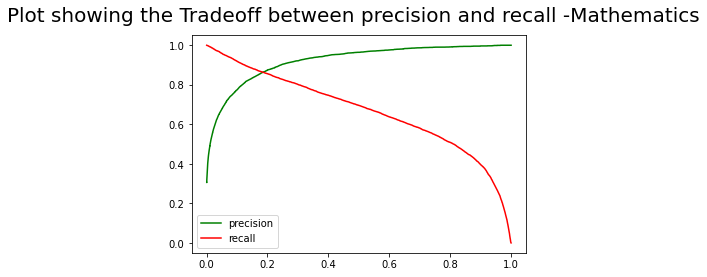

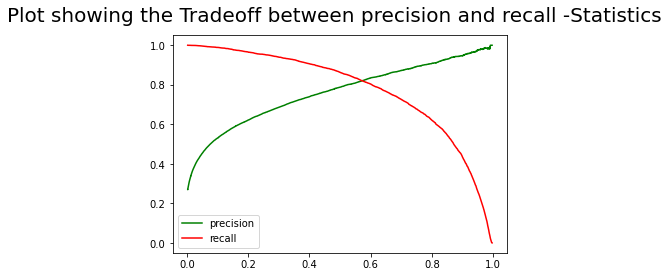

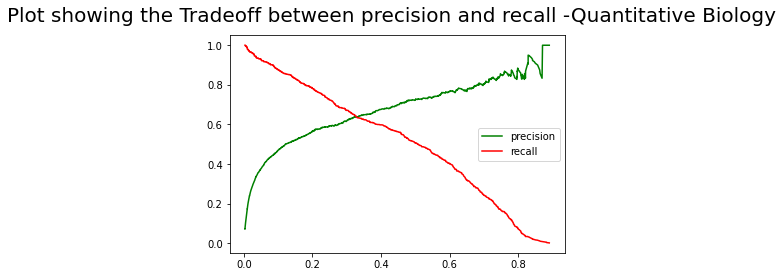

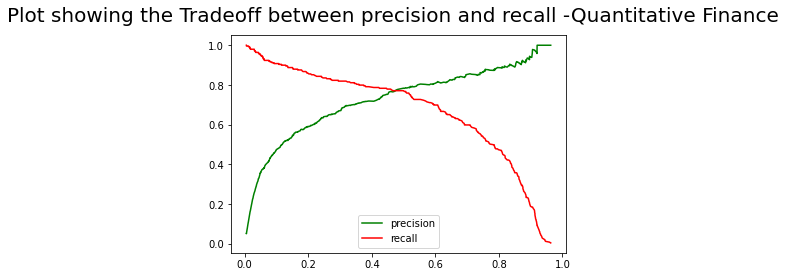

In [ ]:
b = [0,1,2,3,4,5]

from sklearn.metrics import precision_recall_curve

for ind in sub_in_ord:
    p, r, thresholds = precision_recall_curve(train_lab[ind],train_check[ind])
    plt.plot(thresholds, p[:-1], "g-")
    plt.plot(thresholds, r[:-1], "r-")
    plt.legend(['precision','recall'])
    plt.suptitle('Plot showing the Tradeoff between precision and recall -' + ind , size = 20 )
    plt.subplots_adjust(hspace= 0.5)
    plt.show()

##Predictions on the test set

In [ ]:
num_labels = 6
pred_probs = generate_predictions(model, testing, num_labels, device="cuda", batch_size=16)
pred_probs

array([[2.54460573e-01, 1.10486168e-02, 1.24923036e-01, 9.89711761e-01,
        4.11775336e-03, 1.22446148e-02],
       [4.49439511e-03, 9.95770514e-01, 1.51660628e-04, 1.39535069e-02,
        8.03409610e-04, 6.34741038e-04],
       [9.82254446e-01, 1.25649907e-02, 2.04206463e-02, 2.27576997e-02,
        4.38070652e-04, 5.38482273e-04],
       ...,
       [3.63532931e-01, 5.47145940e-02, 2.62154685e-03, 5.29735148e-01,
        6.44238830e-01, 4.72569559e-03],
       [2.37750128e-01, 6.81130169e-03, 1.11611374e-01, 9.58483577e-01,
        1.74456567e-03, 4.78675030e-03],
       [6.42734706e-01, 1.20987101e-02, 1.35490239e-01, 2.44616177e-02,
        1.44195114e-03, 1.35476026e-03]])

In [ ]:
crct = [0.5,0.5,0.42,0.55,0.27, 0.1] #IF YOU WANT TO CHOOSE A OPTIMUM CUTOFF BASED ON PRECISION RECALL CURVE

In [ ]:
sub_in_ord = ['Computer Science', 'Physics', 'Mathematics', 'Statistics','Quantitative Biology', 'Quantitative Finance']

predict = pd.DataFrame(pred_probs , columns = sub_in_ord)
predict.index =testing.index

In [ ]:
# CHOOSING A STABLE CUTOFF OF 0.5 

k = 0
for x in sub_in_ord:
  predict[x] = predict[x].map(lambda y:0 if y < 0.5 else 1)
  k +=1



In [ ]:
predict.to_csv('gpt2_one.csv')

In [ ]:
predict

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,
20973,0,0,0,1,0,0
20974,0,1,0,0,0,0
20975,1,0,0,0,0,0
20976,0,1,0,0,0,0
20977,1,0,0,0,0,0
...,...,...,...,...,...,...
29957,1,0,0,0,0,0
29958,0,0,1,1,0,0
29959,0,0,0,1,1,0


## USING THE ABOVE METHOD MANY TRANSFORMER MODELS WERE FINE TUNED AND SAVED IN THEIR RESPECTIVE PATH. AFTER THAT AN ENSEMBLE FOR 4 TRANSFORMER PREDICTIONS WERE CREATED AND GIVEN FOR SUBMISSION

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
bert = pd.read_csv('/Users/madhavan/Desktop/new /janata_hack/independence_day/bert.csv' , index_col = 'ID')
scibert = pd.read_csv('/Users/madhavan/Desktop/new /janata_hack/independence_day/scibert.csv' , index_col = 'ID')
xlnet = pd.read_csv('/Users/madhavan/Desktop/new /janata_hack/independence_day/xlnet_trail_2.csv' , index_col = 'ID')
gpt_2_one = pd.read_csv('/Users/madhavan/Desktop/new /janata_hack/independence_day/gpt2_one.csv' , index_col = 'ID')


In [ ]:
final_sub = (bert + scibert + xlnet + gpt_2_one)/4
final_sub = final_sub.apply(lambda x:x.map(lambda y:1 if y >= 0.5 else 0))

In [ ]:
final_sub.to_csv('final_sub.csv')